In [8]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import boto3
from sagemaker import get_execution_role
import pandas as pd
import os

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

In [3]:
conn = boto3.resource('s3')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# Prepare Data

In [9]:
annotations = pd.read_csv('./text/text-data.csv')

In [18]:
annotations.shape

(50282, 3)

In [19]:
def check_folder(file):
    if file in os.listdir('./images/train'):
        return 'train'
    elif file in os.listdir('./images/valid'):
        return 'valid'
    else:
        return None

In [20]:
annotations['dataset'] = annotations['image'].apply(lambda x: check_folder(x))

In [21]:
annotations[annotations.dataset == 'valid'].shape

(2500, 3)

In [22]:
annotations[annotations.dataset == 'train'].shape

(7500, 3)

In [29]:
req_annotations = annotations[(annotations.dataset == 'valid') | (annotations.dataset == 'train')]

In [30]:
req_annotations.shape

(10000, 3)

In [49]:
root_dir = '/home/ec2-user/SageMaker/'
images_dir = os.path.join(root_dir, 'images')
tfrecords_dir = os.path.join(root_dir, "tfrecords")

In [40]:
image_path_to_caption = collections.defaultdict(list)
for i in range(len(req_annotations)):
    text = list(req_annotations.text)[i]
    dataset = list(req_annotations.dataset)[i]
    image = list(req_annotations.image)[i]
    caption = f"{text.lower().replace('.', '')}"
    image_path = images_dir + '/' + dataset + '/' + image
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 10000


# Prepare TF Records

In [56]:
train_size = 7500
valid_size = 2500
captions_per_image = 1
images_per_file = 1

train_image_paths = [path for path in image_paths if 'train' in path]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = [path for path in image_paths if 'valid' in path]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

100%|██████████| 7500/7500 [00:04<00:00, 1565.84it/s]


7500 training examples were written to tfrecord files.


100%|██████████| 2500/2500 [00:01<00:00, 1719.00it/s]

2500 evaluation examples were written to tfrecord files.


# Implement Create Dataset

In [65]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

# Implement the projection head

In [57]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

# Implement the vision encoder

In [58]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

# Implement the text encoder

In [59]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        "bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

# Implement the dual encoder

In [60]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Train the dual encoder model

In [67]:
num_epochs = 5  # In practice, train for at least 30 epochs
batch_size = 256

vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [68]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 0
Number of examples (caption-image pairs): 7500
Batch size: 256
Steps per epoch: 30
Epoch 1/5
30/30 [==============================] - 2429s 81s/step - loss: 235.4948 - val_loss: 78.8963
Epoch 2/5
30/30 [==============================] - 2410s 81s/step - loss: 90.9814 - val_loss: 44.8642
Epoch 3/5
30/30 [==============================] - 2406s 81s/step - loss: 49.6884 - val_loss: 26.8933
Epoch 4/5
30/30 [==============================] - 2411s 81s/step - loss: 32.0947 - val_loss: 16.1155
Epoch 5/5
30/30 [==============================] - 2413s 81s/step - loss: 24.6816 - val_loss: 13.0429
Training completed. Saving vision and text encoders...


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Models are saved.


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


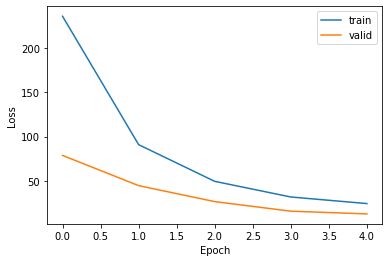

In [69]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

# Generate Embeddings for the Images

In [74]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")

Loading vision and text encoders...
Models are loaded.


In [100]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))

Generating embedding for /home/ec2-user/SageMaker/images/valid/1757.png ...
1/1 [==============================] - 0s 206ms/step
Image embeddings shape: (1, 256).


# Retrieve text for images

In [178]:
def provide_reason(unique_texts, image_path, k=1, normalize=True):
    # Get embedding for input image
    get_image_embedding = vision_encoder.predict(
        tf.expand_dims(read_image(image_path), axis=0),
        verbose=0,
    )
    # Get text embeddings for all possible explanations
    text_embeddings = [text_encoder(tf.convert_to_tensor([text.lower().replace('.', '')])) for text in unique_texts]
    # Normalize text and image embedding
    if normalize:
        image_embedding = tf.math.l2_normalize(get_image_embedding)
        text_embedding = [tf.math.l2_normalize(text) for text in text_embeddings]
    # Obtain dot similarities
    dot_similarity = [dot[0][0].numpy() for dot in tf.matmul(image_embedding, text_embedding, transpose_b=True)]
    # Retrieve top index similarity score
    result_index = dot_similarity.index(max(dot_similarity))
    # Return best explanation sentence match
    return unique_texts[result_index]

In [164]:
sample_image_path_1 = '/home/ec2-user/SageMaker/images/valid/1757.png'

In [179]:
provide_reason(unique_texts, sample_image_path_1)

'Classification for this image is asymmetric anaphase structure. This is explained by two chromosome clusters of unequal size are depicted.'

In [151]:
sample_image_path_2 = '/home/ec2-user/SageMaker/images/valid/16698.png'

In [180]:
provide_reason(unique_texts, sample_image_path_2)

'Phase structure chromosome bridging most evidently described by chromosomes stretching from one pole to other.'

In [153]:
sample_image_path_3 = '/home/ec2-user/SageMaker/images/valid/18270.png'

In [181]:
provide_reason(unique_texts, sample_image_path_3)

'Classification for this image is asymmetric anaphase structure. This is explained by two chromosome clusters of unequal size are depicted.'

In [183]:
sample_image_path_4 = '/home/ec2-user/SageMaker/images/valid/187098.png'

In [184]:
provide_reason(unique_texts, sample_image_path_4)

'All cells are healthy.'

In [193]:
sample_image_path_5 = '/home/ec2-user/SageMaker/images/valid/16743.png'

In [194]:
provide_reason(unique_texts, sample_image_path_5)

'Phase structure chromosome bridging most evidently described by chromosomes stretching from one pole to other.'